In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jun 18 10:06:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install keras_hist_graph

In [3]:
import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten, Input, ZeroPadding2D,InputLayer
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop, SGD
from keras.callbacks import History, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.constraints import unit_norm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras_hist_graph import plot_history
%matplotlib inline

In [4]:
pip install livelossplot

In [12]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import decode_predictions, preprocess_input, VGG16
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from livelossplot.inputs.keras import PlotLossesCallback

In [6]:
#set the training path
training_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/training_data'
#set the validation path
validation_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/validation_data'
#set the test path
test_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data'

In [16]:
def create_model(n_classes,tuning_layers):

  #Import the pre-trained VGG model without the fully connected layers on top
  conv_inception=Xception(weights='imagenet', 
                  include_top = False,
                  input_shape = (224,224, 3))

  #setting the fine-tuning loop
  if tuning_layers==0:
    conv_inception.trainable=False
  else:
    for layer in conv_inception.layers[:-tuning_layers]:
      layer.trainable=False

  #bootstrapping a new top_model into the pre-trained model

  model=Sequential()
  model.add(conv_inception)
  model.add(Flatten())
  model.add(Dense(512, activation='relu',input_shape=(None,38400)))
  model.add(Dropout(0.3))
  model.add(Dense(n_classes,activation='softmax'))

  model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
  
  return model

# 120 Breeds

## Setting the data

In [17]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20)

Found 13297 images belonging to 119 classes.


In [18]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 4055 images belonging to 119 classes.


In [19]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 3037 images belonging to 119 classes.


## No Fine tuning

In [20]:
xception_120breeds=create_model(n_classes=119,tuning_layers=0)

In [21]:
plot_tun0_120=PlotLossesCallback()

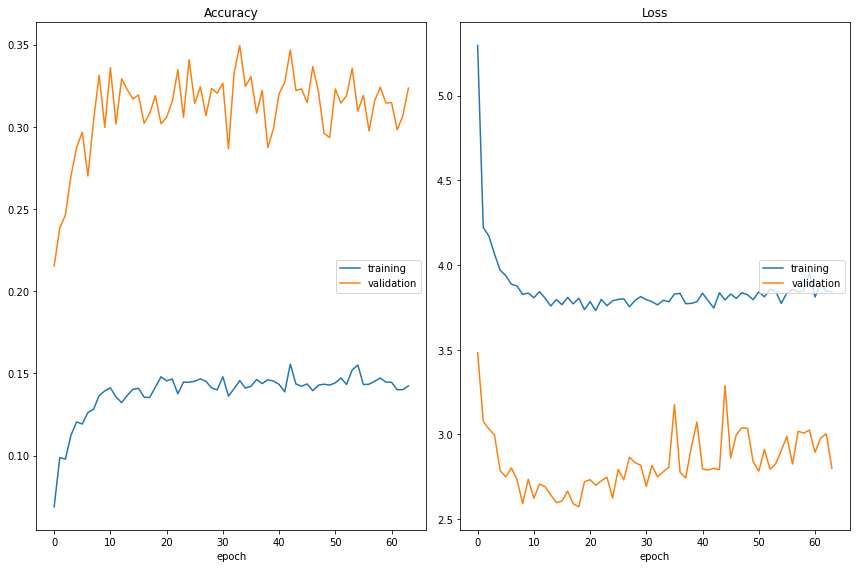

Accuracy
	training         	 (min:    0.069, max:    0.156, cur:    0.142)
	validation       	 (min:    0.215, max:    0.349, cur:    0.324)
Loss
	training         	 (min:    3.731, max:    5.296, cur:    3.844)
	validation       	 (min:    2.574, max:    3.483, cur:    2.801)
Epoch 00064: early stopping


In [22]:
history_xception_120breeds=xception_120breeds.fit(rotation_train,batch_size=40, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Xception/120_breeds/no_fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun0_120
              ]
    )

In [ ]:
aug_test.reset()

In [23]:
xception_120breeds.evaluate(aug_test)

152/152 [==============================] - 942s 6s/step - loss: 2.8705 - acc: 0.3378


[2.870500087738037, 0.33783337473869324]

## fine tuning

In [24]:
xception_1_120breeds=create_model(n_classes=119,tuning_layers=3)

In [25]:
plot_tun1_120=PlotLossesCallback()

In [26]:
rotation_train.reset()

In [27]:
aug_validation.reset()

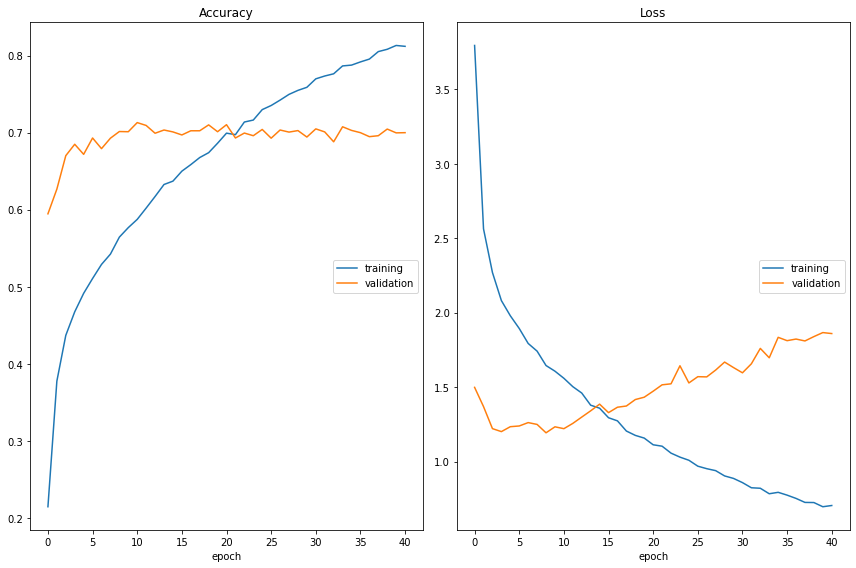

Accuracy
	training         	 (min:    0.214, max:    0.813, cur:    0.812)
	validation       	 (min:    0.595, max:    0.713, cur:    0.700)
Loss
	training         	 (min:    0.698, max:    3.794, cur:    0.706)
	validation       	 (min:    1.194, max:    1.867, cur:    1.860)
Epoch 00041: early stopping


In [28]:
history_xception1_120breeds=xception_1_120breeds.fit(rotation_train,batch_size=40, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Xception/120_breeds/fine_tuning',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun1_120
              ]
    )

In [29]:
aug_test.reset()

In [30]:
xception_1_120breeds.evaluate(aug_test)

152/152 [==============================] - 11s 72ms/step - loss: 1.2836 - acc: 0.6997


[1.283569574356079, 0.6997036337852478]

## fine tuning2

In [31]:
xception_2_120breeds=create_model(n_classes=119,tuning_layers=6)

In [32]:
plot_tun2_120=PlotLossesCallback()

In [33]:
rotation_train.reset()

In [34]:
aug_validation.reset()

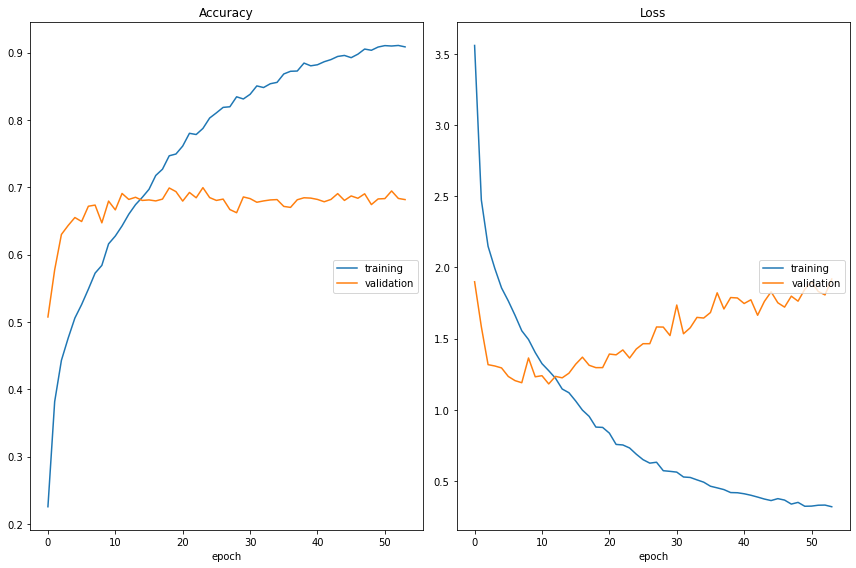

Accuracy
	training         	 (min:    0.225, max:    0.911, cur:    0.908)
	validation       	 (min:    0.507, max:    0.699, cur:    0.682)
Loss
	training         	 (min:    0.318, max:    3.559, cur:    0.318)
	validation       	 (min:    1.181, max:    1.918, cur:    1.918)
Epoch 00054: early stopping


In [35]:
history_xception_2_120breeds=xception_2_120breeds.fit(rotation_train,batch_size=40, epochs=1000, verbose=1,validation_data=aug_validation,
                          callbacks=[History(),
                                     ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/transfer_learning/Xception/120_breeds/fine_tuning2',
                                                     monitor='val_acc', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_acc', patience=30, restore_best_weights=True, verbose=1),plot_tun2_120
              ]
    )

In [36]:
aug_test.reset()

In [37]:
xception_2_120breeds.evaluate(aug_test)

152/152 [==============================] - 11s 69ms/step - loss: 1.4232 - acc: 0.7040


[1.4231692552566528, 0.7039842009544373]